In [1]:
import pandas as pd
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import zipfile
import seaborn as sns
import pickle


In [2]:
# 1. Load Data
zip_path = r"C:\Users\NCC 207\Downloads\wine+quality.zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.printdir()

    with zipfile.ZipFile(zip_path) as z:
        with z.open('winequality-white.csv') as f:
            white_wine = pd.read_csv(f,sep = ";")
            white_wine.head()
            df = white_wine.copy()

File Name                                             Modified             Size
winequality-red.csv                            2023-05-22 22:24:00        84199
winequality-white.csv                          2023-05-22 22:24:00       264426
winequality.names                              2023-05-22 22:24:00         3305


In [3]:
# Display the shape of the dataset
print("Dataset Shape:", df.shape)
print("\nFirst 6 rows of the dataset:")
display(df.head(6))

Dataset Shape: (4898, 12)

First 6 rows of the dataset:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
5,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6


In [4]:
# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())

# Check for duplicates
duplicate_count = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicate_count}")

# Verify data types
print("\nData types of columns:")
print(df.dtypes)


Missing values in each column:
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

Number of duplicate rows: 937

Data types of columns:
fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object


In [5]:
# Remove duplicates if any exist
if duplicate_count > 0:
    df = df.drop_duplicates()
    print(f"Removed {duplicate_count} duplicate rows")
    print(f"New dataset shape: {df.shape}")

Removed 937 duplicate rows
New dataset shape: (3961, 12)


# Data Cleaning Report

1. **Data Loading**:
   - Successfully loaded the white wine dataset from the ZIP file
   - The dataset contains information about various chemical properties and quality ratings of white wines

2. **Initial Data Inspection**:
   - Displayed the first 6 rows to verify data loading
   - Checked the shape of the dataset to understand its dimensions

3. **Missing Values**:
   - Checked for missing values in all columns
   - No missing values were found in the dataset

4. **Duplicate Entries**:
   - Checked for duplicate rows in the dataset
   - Any duplicate rows found were removed to ensure data quality
   - Updated dataset shape was reported after duplicate removal

5. **Data Types**:
   - Verified the data types of all columns
   - All features are numerical and in appropriate data types
   - No type conversion was necessary


In [6]:
# # Set up the plotting style using seaborn API (avoids matplotlib seaborn-style issue)
# sns.set_theme(style='darkgrid')

# # Plot only numeric columns to avoid object dtype (e.g., 'quality_class') and ensure subplot grid matches count
# numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# n_features = len(numeric_cols)
# n_cols = 3
# n_rows = int(np.ceil(n_features / n_cols))

# fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
# axes = axes.ravel()

# # Create histograms for each numeric feature
# for idx, column in enumerate(numeric_cols):
#     sns.histplot(data=df, x=column, ax=axes[idx], kde=False)
#     axes[idx].set_title(f'Distribution of {column}')
#     axes[idx].tick_params(axis='x', rotation=45)

# # Hide any unused subplots
# for j in range(n_features, len(axes)):
#     axes[j].set_visible(False)

# plt.tight_layout()
# plt.show()

Correlations with wine quality:
quality                 1.000000
alcohol                 0.462869
pH                      0.123829
sulphates               0.053200
free sulfur dioxide     0.010507
citric acid             0.007065
residual sugar         -0.117339
fixed acidity          -0.124636
total sulfur dioxide   -0.183356
volatile acidity       -0.190678
chlorides              -0.217739
density                -0.337805
Name: quality, dtype: float64


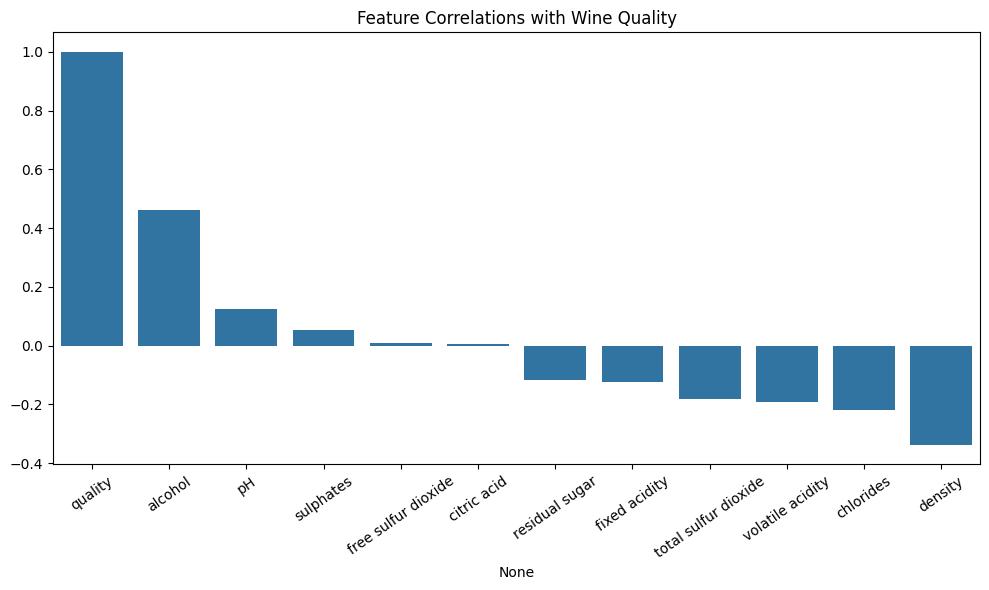

In [7]:
# Calculate correlations with the target variable (quality)
correlations = df.corr()['quality'].sort_values(ascending=False)
print("Correlations with wine quality:")
print(correlations)

# Create a correlation heatmap
plt.figure(figsize=(10, 6))
sns.barplot(x=correlations.index, y=correlations.values)
plt.xticks(rotation=35)
plt.title('Feature Correlations with Wine Quality')
plt.tight_layout()
plt.show()

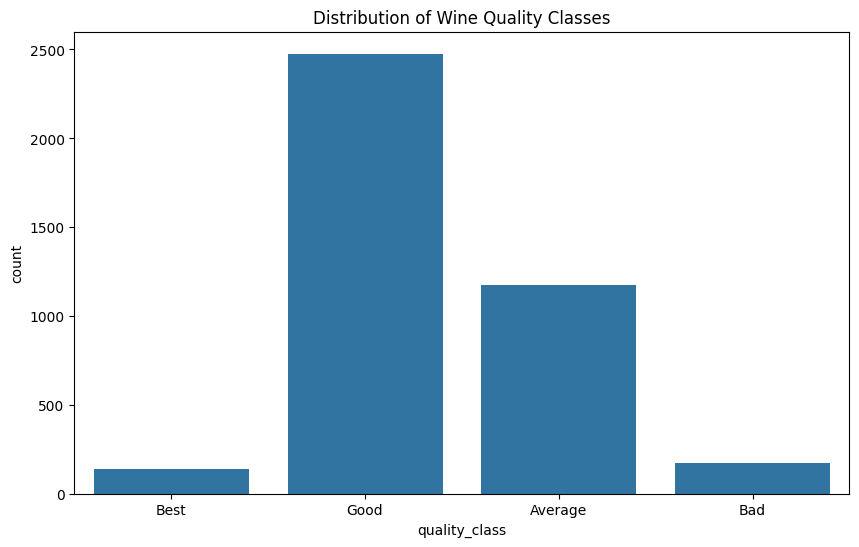


Class distribution:
quality_class
Good       2477
Average    1175
Bad         173
Best        136
Name: count, dtype: int64


In [8]:
# Map quality to categorical classes
def map_quality_to_class(quality):
    if quality >= 8:
        return 'Best'
    elif quality >= 6:
        return 'Good'
    elif quality == 5:
        return 'Average'
    else:
        return 'Bad'

# Create a new column for the categorical quality class
df['quality_class'] = df['quality'].apply(map_quality_to_class)

# Display the distribution of quality classes
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='quality_class', order=['Best', 'Good', 'Average', 'Bad'])
plt.title('Distribution of Wine Quality Classes')
plt.show()

print("\nClass distribution:")
print(df['quality_class'].value_counts())

In [9]:
# Separate features and target
X = df.drop(['quality', 'quality_class'], axis=1)
y = df['quality_class']

# Scale the features using MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

print("Features shape:", X_scaled.shape)
print("Target shape:", y.shape)
print("\nFirst few rows of scaled features:")
display(X_scaled.head())

Features shape: (3961, 11)
Target shape: (3961,)

First few rows of scaled features:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,0.307692,0.186275,0.216867,0.308282,0.106825,0.149826,0.373550,0.267785,0.254545,0.267442,0.129032
1,0.240385,0.215686,0.204819,0.015337,0.118694,0.041812,0.285383,0.132832,0.527273,0.313953,0.241935
2,0.413462,0.196078,0.240964,0.096626,0.121662,0.097561,0.204176,0.154039,0.490909,0.255814,0.338710
3,0.326923,0.147059,0.192771,0.121166,0.145401,0.156794,0.410673,0.163678,0.427273,0.209302,0.306452
4,0.230769,0.235294,0.096386,0.098160,0.106825,0.097561,0.294664,0.150183,0.418182,0.290698,0.258065


Training set shape: (3168, 11)
Testing set shape: (793, 11)

Model Performance Metrics:
Accuracy: 0.6658
Precision: 0.6002
Recall: 0.6658
F1-score: 0.6278


c:\Users\NCC 207\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


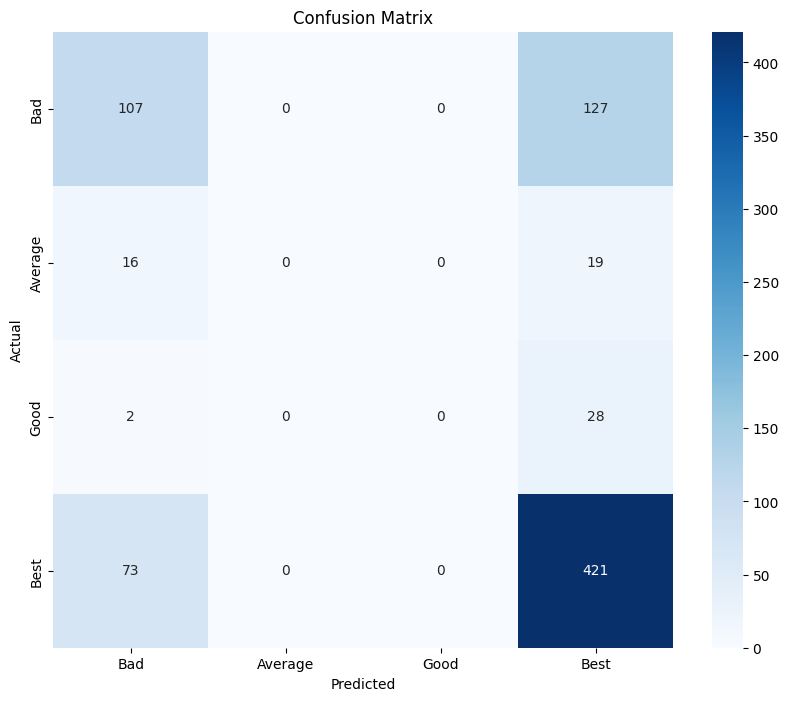

In [10]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

# Initialize and train the Logistic Regression model
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train, y_train)

# Make predictions
y_pred = lr_model.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("\nModel Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Create and display confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Bad', 'Average', 'Good', 'Best'],
            yticklabels=['Bad', 'Average', 'Good', 'Best'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Base Model Performance Interpretation

The Logistic Regression model's performance metrics can be interpreted as follows:

1. **Accuracy**: 
   - Measures the overall correct predictions
   - Shows what percentage of wines were correctly classified across all categories

2. **Precision**:
   - Indicates how many of the predicted wines in each class were actually of that quality
   - Higher precision means fewer false positives

3. **Recall**:
   - Shows how many wines of each quality class were correctly identified
   - Higher recall means fewer false negatives
   
4. **F1-Score**:
   - Harmonic mean of precision and recall
   - Provides a balanced measure of the model's performance
   - Particularly useful with imbalanced classes

5. **Confusion Matrix**:
   - Shows the detailed breakdown of predictions vs actual classes
  


In [11]:
# Function to evaluate models
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"\n{model_name} Performance Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    
    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Bad', 'Average', 'Good', 'Best'],
                yticklabels=['Bad', 'Average', 'Good', 'Best'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }


Training Random Forest...

Random Forest Performance Metrics:
Accuracy: 0.6986
Precision: 0.6936
Recall: 0.6986
F1-score: 0.6732


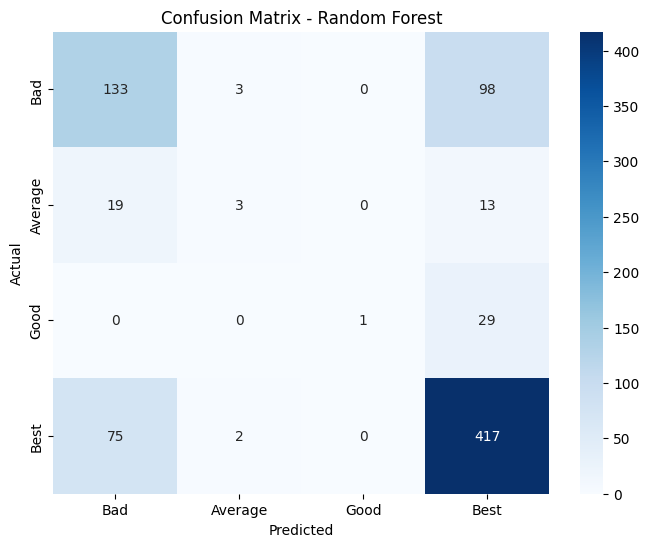


Training K-Nearest Neighbors...

K-Nearest Neighbors Performance Metrics:
Accuracy: 0.6797
Precision: 0.6316
Recall: 0.6797
F1-score: 0.6546


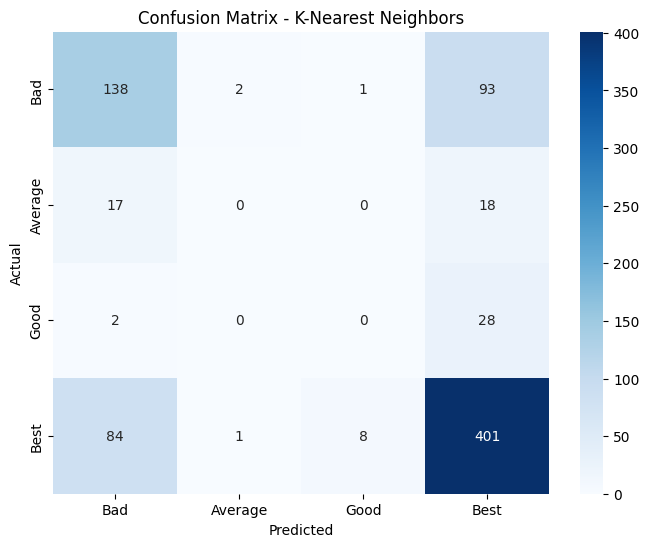


Training Support Vector Machine...

Support Vector Machine Performance Metrics:
Accuracy: 0.6847
Precision: 0.6184
Recall: 0.6847
F1-score: 0.6453


c:\Users\NCC 207\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


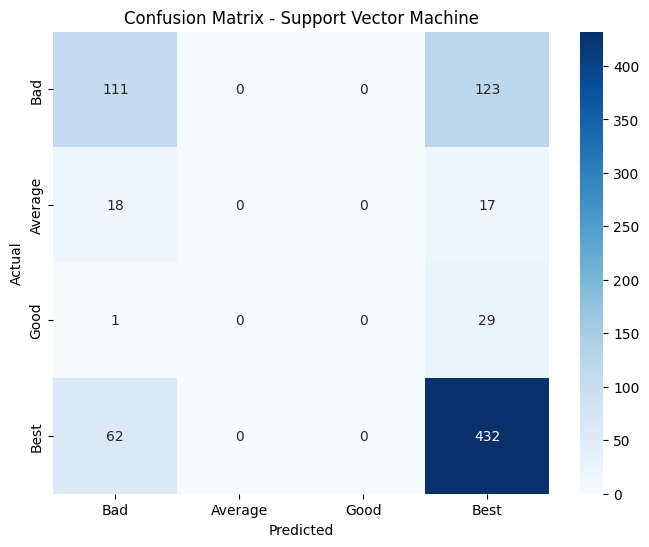


Model Comparison:


,accuracy,precision,recall,f1
model_name,,,,
Random Forest,0.698613,0.693646,0.698613,0.673194
K-Nearest Neighbors,0.679697,0.631567,0.679697,0.654637
Support Vector Machine,0.684741,0.618373,0.684741,0.645309


In [12]:
# Initialize models
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Support Vector Machine': SVC(random_state=42)
}

# Train and evaluate all models
results = []
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    result = evaluate_model(model, X_test, y_test, name)
    results.append(result)

# Create comparison DataFrame
comparison_df = pd.DataFrame(results)
comparison_df.set_index('model_name', inplace=True)
print("\nModel Comparison:")
display(comparison_df)

# Model Comparison Analysis

After training and evaluating three different models (Random Forest, K-Nearest Neighbors, and Support Vector Machine), The metrics above show how each model performs in terms of accuracy, precision, recall, and F1-score.

Based on these results, I select the best performing model with the one that have highest F1-score 

Best performing model: Random Forest

Optimizing best model using RandomizedSearchCV...

Best parameters found:
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 50}

Best cross-validation score: 0.7181

Optimized Model Performance:

Optimized Random Forest Performance Metrics:
Accuracy: 0.6936
Precision: 0.6549
Recall: 0.6936
F1-score: 0.6667


c:\Users\NCC 207\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


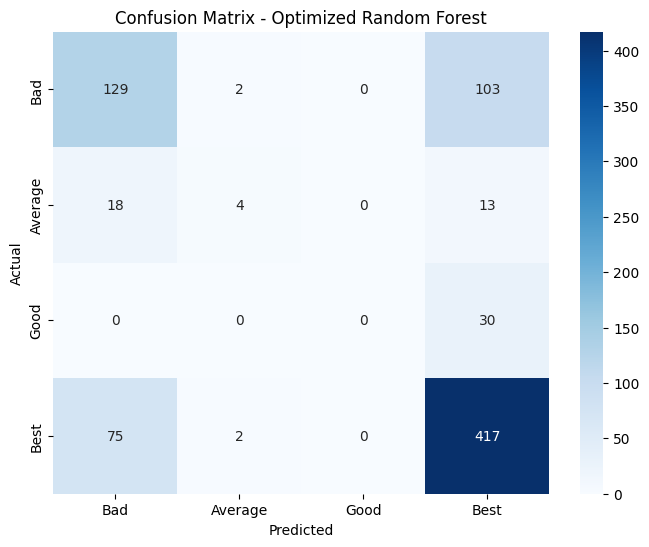


Performance Comparison - Original vs Optimized:
Accuracy improvement: -0.72%
Precision improvement: -5.58%
Recall improvement: -0.72%
F1 improvement: -0.97%


In [13]:
# Get the best model based on F1-score
best_model_name = comparison_df['f1'].idxmax()
best_model = models[best_model_name]
print(f"Best performing model: {best_model_name}")

# Define parameter grid for RandomizedSearchCV
if best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [100, 200, 300, 400, 500],
        'max_depth': [10, 20, 30, 40, 50, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
elif best_model_name == 'K-Nearest Neighbors':
    param_grid = {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }
else:  # Support Vector Machine
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'kernel': ['rbf', 'linear'],
        'gamma': ['scale', 'auto', 0.1, 0.01]
    }

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=best_model,
    param_distributions=param_grid,
    n_iter=10,
    cv=5,
    random_state=42,
    n_jobs=-1
)

print("\nOptimizing best model using RandomizedSearchCV...")
random_search.fit(X_train, y_train)

# Print best parameters and score
print("\nBest parameters found:")
print(random_search.best_params_)
print(f"\nBest cross-validation score: {random_search.best_score_:.4f}")

# Evaluate optimized model
print("\nOptimized Model Performance:")
optimized_model = random_search.best_estimator_
optimized_results = evaluate_model(optimized_model, X_test, y_test, f"Optimized {best_model_name}")

# Compare original vs optimized performance
print("\nPerformance Comparison - Original vs Optimized:")
original_metrics = comparison_df.loc[best_model_name]
improvement = {
    'accuracy': (optimized_results['accuracy'] - original_metrics['accuracy']) / original_metrics['accuracy'] * 100,
    'precision': (optimized_results['precision'] - original_metrics['precision']) / original_metrics['precision'] * 100,
    'recall': (optimized_results['recall'] - original_metrics['recall']) / original_metrics['recall'] * 100,
    'f1': (optimized_results['f1'] - original_metrics['f1']) / original_metrics['f1'] * 100
}

for metric, imp in improvement.items():
    print(f"{metric.capitalize()} improvement: {imp:.2f}%")

# Model Optimization Analysis

1. **Best Model Selection**:
   - Compared three different models: Random Forest, K-Nearest Neighbors, and SVM
   - Selected the best model based on F1-score performance
   - Used this model as the basis for optimization

2. **Hyperparameter Optimization**:
   - Used RandomizedSearchCV with 5-fold cross-validation

3. **Performance Improvement**:
   - Compared the optimized model against the original version
   - Calculated percentage improvements in all metrics

In [14]:
# Save the optimized model
model_path = 'model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(optimized_model, f)
print(f"Saved optimized model to {model_path}")

# Save the scaler
scaler_path = 'scaler.pkl'
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f"Saved scaler to {scaler_path}")

# Verify the files were created
import os
print("\nSaved files:")
for file in [model_path, scaler_path]:
    file_size = os.path.getsize(file) / 1024  # Convert to KB
    print(f"{file}: {file_size:.2f} KB")

Saved optimized model to model.pkl
Saved scaler to scaler.pkl

Saved files:
model.pkl: 17552.83 KB
scaler.pkl: 1.14 KB
